In [1]:
"""
Our development focused on finding the busiest station by counting entries and exits per station per day
This data is then complimented with demographic information from the Census 2015's 5 year outlook

Our data set utilized pandas and numpy for math functions
Graphics are generated by using matplotlib

"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# We utilized the sample code from Alice to retrieve 4 weeks May turnstile data from MTA
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [190525, 190518, 190511, 190504] #weeks in May 2019
df = get_data(week_nums)

In [3]:
# we initally only pulled the last week's data to trial run on a smaller dataset
#df = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_200627.txt', header = 0)

In [4]:
# originally we did not apply the "cleanup" to all the titles of the columns
#df.rename(columns={'EXITS                                                               ':'EXITS'}, inplace=True)

In [5]:
df.columns = df.columns.str.strip() # stripping the spaces from col titles

In [6]:
df['Date_Time'] = df['DATE'] + ' ' + df['TIME']

In [7]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'])

In [8]:
df = df[df['DESC'] == 'REGULAR'] # filtering out non REGULAR entries

In [9]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,00:00:00,REGULAR,7062481,2393489,2019-05-18 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,04:00:00,REGULAR,7062505,2393492,2019-05-18 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,08:00:00,REGULAR,7062529,2393526,2019-05-18 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,12:00:00,REGULAR,7062627,2393612,2019-05-18 12:00:00
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,20:00:00,REGULAR,7063097,2393696,2019-05-18 20:00:00


In [10]:
# since it appears each entry and exit tallys by the turnstile, 
# we used the max and min method to obtain counter per day per turnstile
mta_entries = df.groupby(['STATION','C/A','UNIT','SCP','DATE','LINENAME']).ENTRIES.max() - \
df.groupby(['STATION','C/A','UNIT','SCP','DATE','LINENAME']).ENTRIES.min()
mta_exits = df.groupby(['STATION','C/A','UNIT','SCP','DATE','LINENAME']).EXITS.max() - \
df.groupby(['STATION','C/A','UNIT','SCP','DATE','LINENAME']).EXITS.min()

## resetting index of the data to make it flat
mta_entries_flat = mta_entries.reset_index()
mta_exits_flat = mta_exits.reset_index()
# merging entries and exits together
mta_entries_exits = pd.merge(mta_entries_flat, mta_exits_flat, how='outer')

In [11]:
# we observed outlyers in our data with can skew the result set.
# so we chose to use the quantile function for 99.9% to eliminate outlyers
mta_entries_exits.ENTRIES.quantile(.9993) 

14885.78000000806

In [12]:
mta_entries_exits.EXITS.quantile(.9993)

11798.455000000395

In [13]:
mta_entries_exits['EXITS'].abs() # we also noted turnstiles with negative counts which we assume is reversed

0          132
1          115
2         3362
3         3658
4         3585
          ... 
134946       0
134947       1
134948       0
134949       0
134950       0
Name: EXITS, Length: 134951, dtype: int64

In [14]:
# based on quantile findings we have set the thresh hold at 20,000
mta_traffic = mta_entries_exits[(mta_entries_exits['ENTRIES'] < 20000) & \
                                (mta_entries_exits['EXITS'] < 20000) & (mta_entries_exits['ENTRIES'] > 1) & \
                                (mta_entries_exits['EXITS'] > 1)]


In [15]:
mta_traffic

,STATION,C/A,UNIT,SCP,DATE,LINENAME,ENTRIES,EXITS
2,1 AV,H007,R248,00-00-00,04/29/2019,L,3227,3362
3,1 AV,H007,R248,00-00-00,04/30/2019,L,3585,3658
4,1 AV,H007,R248,00-00-00,05/01/2019,L,3440,3585
5,1 AV,H007,R248,00-00-00,05/02/2019,L,4288,3279
6,1 AV,H007,R248,00-00-00,05/03/2019,L,3393,3710
...,...,...,...,...,...,...,...,...
134890,ZEREGA AV,R419,R326,00-03-01,05/20/2019,6,1187,181
134891,ZEREGA AV,R419,R326,00-03-01,05/21/2019,6,1280,223
134892,ZEREGA AV,R419,R326,00-03-01,05/22/2019,6,1265,200
134893,ZEREGA AV,R419,R326,00-03-01,05/23/2019,6,1229,172


In [16]:
mta_station_rank = mta_traffic.groupby(['STATION','LINENAME']).sum() # getting total count by station

In [17]:
mta_rank = mta_station_rank.sort_values(by='ENTRIES', ascending = True).tail(20).reset_index()
mta_rank

,STATION,LINENAME,ENTRIES,EXITS
0,59 ST,456NQRW,881472,1027828
1,96 ST,123,882081,822167
2,LEXINGTON AV/53,EM6,890919,976132
3,W 4 ST-WASH SQ,ABCDEFM,918282,953480
4,72 ST,123,923525,921306
5,86 ST,456,977133,971328
6,CANAL ST,JNQRZ6W,1099992,833536
7,PATH NEW WTC,1,1162669,1085562
8,JKSN HT-ROOSVLT,EFMR7,1174578,778454
9,34 ST-PENN STA,123ACE,1175761,1045000


In [18]:
# creating a new column for total traffic to include entries and exits
mta_rank['TotalTraf'] = mta_rank['ENTRIES'] + mta_rank['EXITS']
mta_final = mta_rank.sort_values(by = 'TotalTraf', ascending = True)

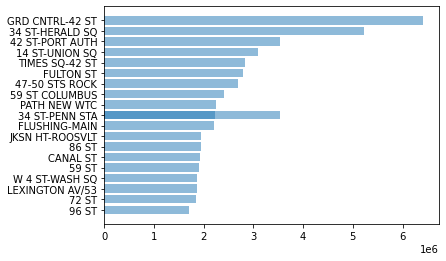

In [19]:
# graphing busiest station by total traffic
plt.barh(mta_final['STATION'],mta_final['TotalTraf'], alpha = 0.5);

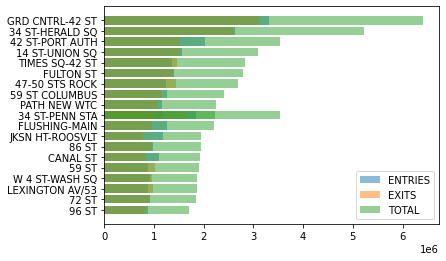

In [20]:
# sampling the make up of the busiest stations
plt.barh(mta_final['STATION'],mta_final['ENTRIES'], alpha = 0.5)
plt.barh(mta_rank['STATION'],mta_rank['EXITS'], alpha = 0.5)
plt.barh(mta_rank['STATION'],mta_rank['TotalTraf'], alpha = 0.5)
plt.legend(['ENTRIES','EXITS','TOTAL']);

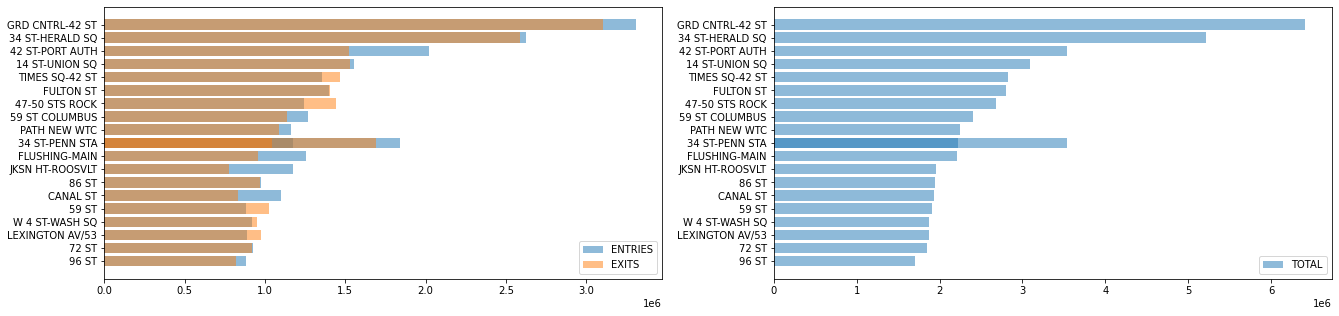

In [21]:
# worked with different set of graphs to determine the best presentation
plt.figure(figsize = [22,5])
plt.subplot(1,2,1)
plt.barh(mta_final['STATION'],mta_final['ENTRIES'], alpha = 0.5)
plt.barh(mta_final['STATION'],mta_final['EXITS'], alpha = 0.5)
plt.legend(['ENTRIES','EXITS']);
plt.subplot(1,2,2)
plt.barh(mta_final['STATION'],mta_final['TotalTraf'], alpha = 0.5)
plt.legend(['TOTAL']);

In [22]:
# using list comprehension to graph each station with both entries and exits
y_ticks = [station for station in mta_final['STATION']]
y_ticks
location = range(1,41,2)

entry_data = 1  # This is our first dataset (out of 2)
ds_num = 2 # Number of datasets
bar = 20 # Number of sets of bars
graph_w = .8 # Width of each bar
Entries = [ds_num*element + graph_w*entry_data for element
             in range(bar)]
exit_data = 2  # This is our second dataset (out of 2)
Exits = [ds_num*element + graph_w*exit_data for element
             in range(bar)]

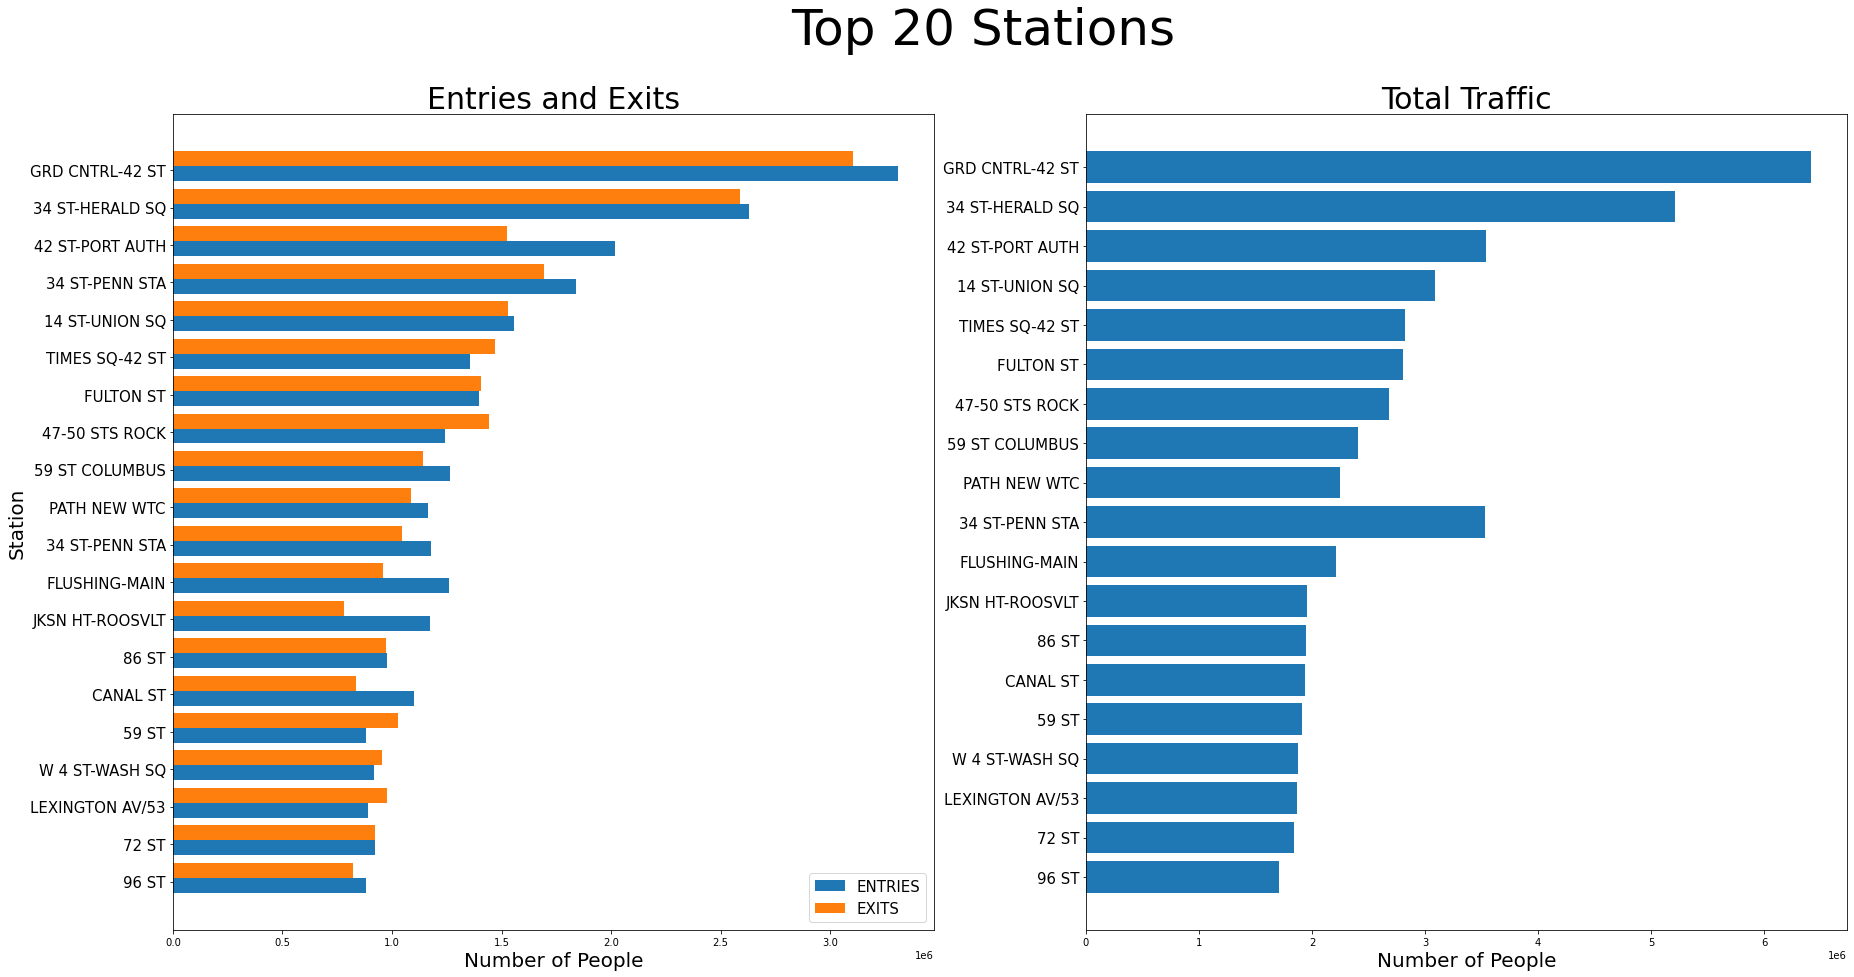

In [23]:
# generated horizonal bar chart for top 20 stations
plt.figure(figsize = [30,15])
plt.suptitle('Top 20 Stations', fontsize = 50)
plt.subplot(1,2,1)
plt.barh(Entries,mta_final['ENTRIES'])
plt.barh(Exits,mta_final['EXITS'])
plt.yticks(location, y_ticks, fontsize = 15)
plt.legend(['ENTRIES','EXITS'], fontsize = 15)
plt.title('Entries and Exits', fontsize=30)
plt.xlabel('Number of People', fontsize=20)
plt.ylabel('Station', fontsize=20);
plt.subplot(1,2,2)
plt.yticks(fontsize = 15)
plt.barh(mta_final['STATION'],mta_final['TotalTraf'])
# plt.legend(['TOTAL'], fontsize = 15)
plt.title('Total Traffic', fontsize=30)
plt.xlabel('Number of People', fontsize=20)
# plt.ylabel('Station', fontsize=20);
plt.savefig('top_20.png');

In [24]:
# getting census and tract information to be used to determine demographic information with lat and lon
# this dataset was obtained from https://www.kaggle.com/muonneutrino/mapping-new-york-city-census-data/
blocks = pd.read_csv('census_block_loc.csv')
census = pd.read_csv('datasets_1682_3159_nyc_census_tracts.csv',index_col=0)

In [25]:
# selecting the counties in NYC
blocks = blocks[blocks.County.isin(['Bronx','Kings','New York','Queens','Richmond'])]
# using floor division to group the tract by blockcode
blocks['Tract'] = blocks.BlockCode // 10000
# merging the demo data with tract details
blocks = blocks.merge(census,how='left',right_index=True,left_on='Tract') 

In [26]:
blocks.info(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18053 entries, 15 to 37111
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Latitude         18053 non-null  float64
 1   Longitude        18053 non-null  float64
 2   BlockCode        18053 non-null  int64  
 3   County_x         18053 non-null  object 
 4   State            18053 non-null  object 
 5   Tract            18053 non-null  int64  
 6   County_y         18052 non-null  object 
 7   Borough          18052 non-null  object 
 8   TotalPop         18052 non-null  float64
 9   Men              18052 non-null  float64
 10  Women            18052 non-null  float64
 11  Hispanic         12999 non-null  float64
 12  White            12999 non-null  float64
 13  Black            12999 non-null  float64
 14  Native           12999 non-null  float64
 15  Asian            12999 non-null  float64
 16  Citizen          18052 non-null  float64
 17  Income     

In [27]:
# calling the convert to 2d function and make_plot from custom library

from lonlatmap import convert_to_2d
from lonlatmap import make_plot

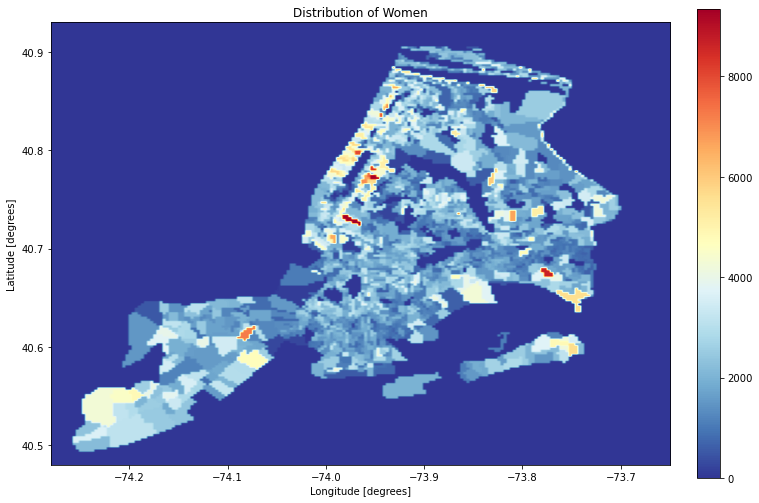

In [28]:
# we filtered out unexplained high number of female concentration and graphed the distribution
make_plot(blocks, blocks[blocks['Women'] < 11000].Women,colors='RdYlBu_r',title='Distribution of Women')

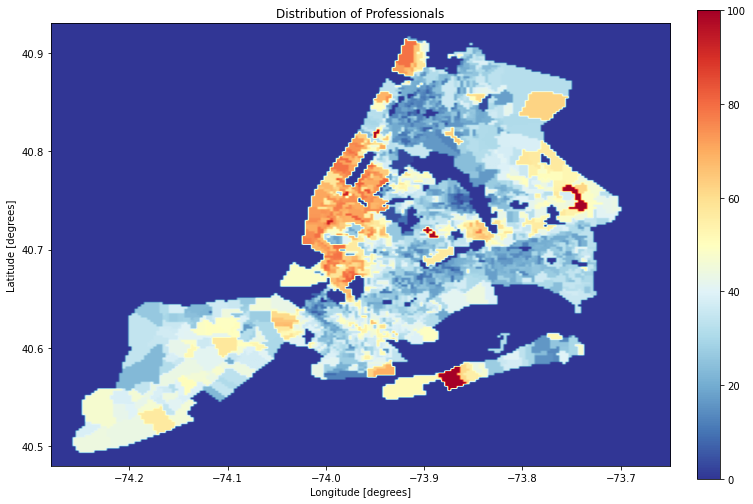

In [29]:
# this graph is intended to determine the concentration of professionals 
make_plot(blocks, blocks.Professional,colors='RdYlBu_r',title='Distribution of Professionals')

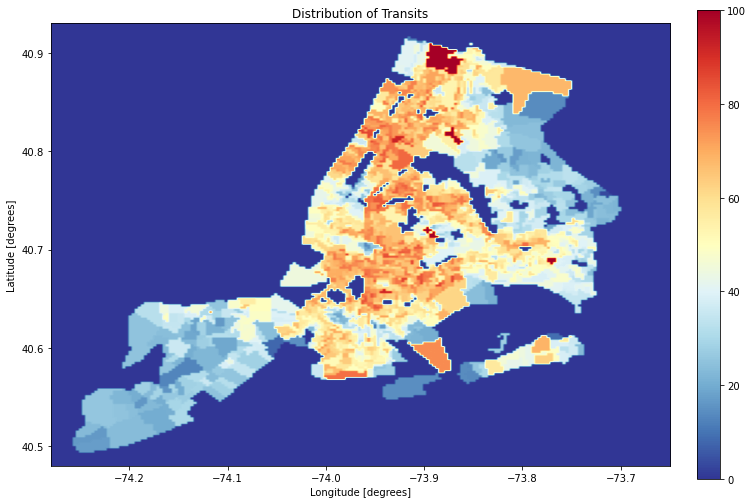

In [30]:
# concentration of people that commute by transits
make_plot(blocks, blocks.Transit,colors='RdYlBu_r',title='Distribution of Transits')